In [1]:
import numpy as np
import math as mt
from sao.functions._functions import *
from sao.functions.telescope import *
from sao.functions.zernike import *
import matplotlib.pyplot as plt
import torch

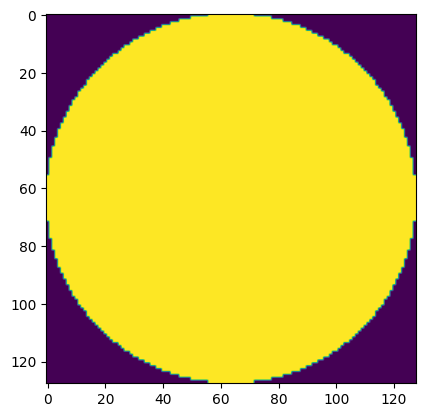

In [2]:
nPx = 128# in pixels
dxy = 1/(nPx)# in meters
D = (nPx)*dxy# in meters
tel = Telescope(nPx,D,dxy=dxy,fov=0,offset=[0,0],shape='circ')
plt.imshow(tel.pupil)


------------------------------------------------ ZERNIKE class ------------------------------------------------
nPx=128 | jModes=[2, 3, 4, 5] | norm=pm1
---------------------------------------------------------------------------------------------------------------


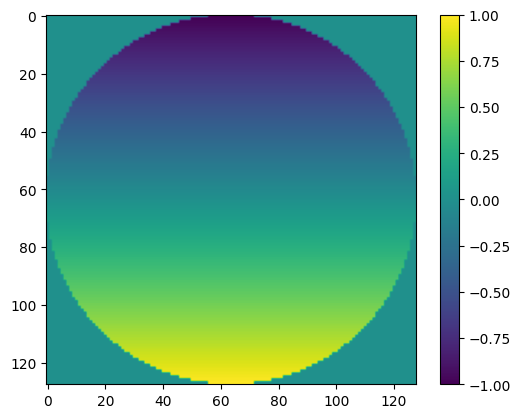

In [3]:
zern = Zernike(tel, jModes=[2,3,4,5],norm='pm1')
z = zern.zModes[:,1].reshape(nPx,nPx)
plt.imshow(z)
plt.colorbar()

Fourier transform

In [5]:
def ft2(input, d, dim=(-2,-1)):
    if len(input.shape) != 4: raise ValueError('Dimension must be (b,c,N,M)')
    """Discrete Direct Fourier Transform

    Input:
        input (input):  2D input field of dim=(b,c,N,M)\n
        dxy (float):    Grid spacing\n
        dim (optional): Dimension along FT2 is computed

    Output:
        (input):        Output field
    """
    return torch.fft.fftshift(torch.fft.fft2(torch.fft.fftshift(input), dim=dim)) * d**2
def ift2(input, df, dim=(-2,-1)):
    if len(input.shape) != 4: raise ValueError('Dimension must be (b,c,N,M)')
    """Discrete Inverse Fourier Transform

    Input:
        input (input):      2D input field of dim=(b,c,N,M)\n
        dfxy (float):       Frequency grid spacing\n
        dim (optional):     Dimension along FT2 is computed

    Output:
        (input):            Output field
    """
    return torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(input), dim=dim))* (input.shape[-1]*df)**2

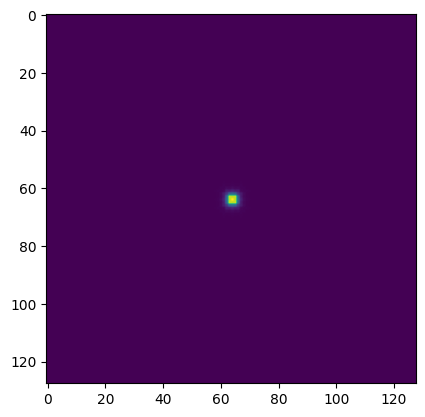

In [54]:
def ones_fresnel_integral(u1, wvl, d1, z):
    """_summary_

    Args:
        u1 (_type_): _description_
        wvl (_type_): _description_
        d1 (_type_): _description_
        z1 (_type_): _description_
    """
    if len(input.shape) != 4: raise ValueError('Dimension must be (b,c,N,M)')
    N = u1.shape[-1]
    k = 2*torch.pi/wvl
    x1,y1,_,_ = get_coordinates(N, d1, offset=[0,0])# source plane
    df1 = 1/(N*d1)
    d2 = wvl*z*df1
    x2,y2,_,_ = get_coordinates(N, d2, offset=[0,0])
    # eval integral
    outer = (torch.exp(torch.tensor(1j)*k*z)/(1j*wvl*z))*torch.exp((1j*k/(2*z))*(x2**2+y2**2))
    inner = u1*torch.exp((1j*k/(2*z))*(x1**2+y1**2))
    u2 = outer*ft2(inner, d=d1, dim=(-2,-1))
    return u2,(d2,x2,y2)

zer = zern.zModes[:,2].reshape(1,1,nPx,nPx)
input = tel.pupil*torch.exp(1j*zer)
u2,cor2 = ones_fresnel_integral(input,635e-6,3.7e-3,100)

plt.imshow(torch.abs(u2.squeeze())**2)

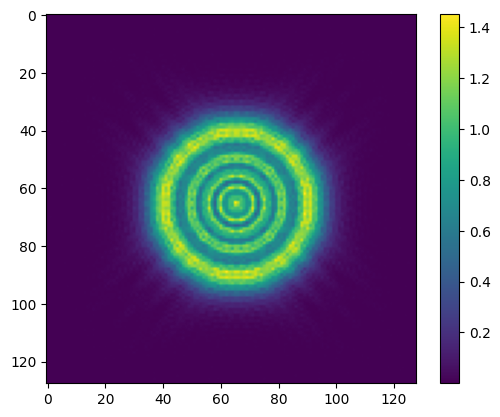

In [116]:
def twos_fresnel_integral(u1, wvl, d1,d2, z1):
    """Two step Fresnel-integral propagation\n
    There are four possible geometries which consider the sign of m:\n
    1. Forward-Forward, Backward-Backward for m>0
    2. Forward-Backward, Backward-Forward for m<0
    (z2a/z1a)=+-m, and m=dx2/dx1\n
    The sign of m consider both cases with negative-positive distances.
    In theory, all m can be simulated with +m
    Input:
        u1 (b,c,N,M):       Input complex wave
        wvl (float):        Wavelength
        d1 (float):         Grid spacing in source plane
        d2 (float):         Desired grid spacing in observation plane
        z1 (float):         Distance between source-observation planes
    Output:
        u2 (b,c,N,M):       Observation complex wave
        cor2 (dx2,x2,y2):   Grid spacing, and coordinates at observation plane
    """
    if len(u1.shape) != 4: raise ValueError('Dimension must be (b,c,N,M)')
    m = d2/d1# magnification
    # z1a, -m for FB and BF, +m for FF and BB
    z1a = z1/(1+m)
    u1a,cor1a = ones_fresnel_integral(u1, wvl, d1, z1a)
    u2,cor2 = ones_fresnel_integral(u1a, wvl, cor1a[0], z1-z1a)# aqui los x2,y2 deben ser meshgrid(N*d2) directamente
    return u2,cor2

zer = zern.zModes[:,2].reshape(1,1,nPx,nPx)
input = tel.pupil*torch.exp(1j*zer)
u2,cor2 = twos_fresnel_integral(input, 635e-6, 3.7e-3,2*3.7e-3, 10)
fx,fy = torch.fft.fftshift(cor2[1]),torch.fft.fftshift(cor2[2])
plt.imshow(torch.abs(u2.squeeze())**2)#,extent=(fx[0], fx[-1], fy[0], fy[-1]))
plt.colorbar()

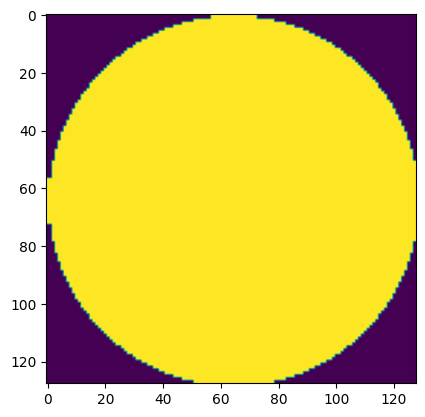

In [39]:
z = zern.zModes[:,0].reshape(1,1,nPx,nPx)
input = tel.pupil*torch.exp(1j*z)
fourier_plane = ft2(input, d=1e-3, dim=(-2,-1))
detector_plane = ft2(fourier_plane, d=1e-3, dim=(-2,-1))
plt.imshow( torch.abs(detector_plane.squeeze())**2 )

# PROPAGATIONS

### a) One-step fresnel-integral propagation

In [ ]:
def one_step_prop(u1, wvl, z, dx):
    k = 2*np.pi/wvl
    N = u1.shape[-1]# square grid
    n = np.linspace( -(N-1)//2, (N-1)//2, N )
    y,x = np.meshgrid(n*dx,n*dx, indexing='ij')
    dfx = 1/(N*dx)# frequency spacing fx
    dxi = wvl*dfx*z# frequency spacing fxi
    eta,xi = np.meshgrid(n*dxi,n*dxi, indexing='ij')
    outer = (np.exp( 1j * k * z) / (1j * wvl * z)) * np.exp((1j * k / (2 * z)) * (xi**2 + eta**2))
    inner = u1 * np.exp((1j * k / (2 * z)) * (x**2 + y**2))
    u2 = outer * ft2(inner, dx, axes=(-2, -1))
    return u2

### b) Two-step fresnel-integral propagation

In [ ]:
def two_step_prop(u1,wvl,dx,dxi,z):
    """Two step fresnel-integral propagation

    Input:
        u1 (ndarray):   Complex input field\n
        wvl (float):    Wavelength of field\n
        dx (float):     Grid spacing of input plane\n
        dxi (float):    Grid spacing of output plane\n
        z (float):      Propagation distance along optical axis
    
    Output:
        (ndarray):      Complex outputt field
    """
    N = u1.shape[0] # number of grid points
    k = 2*np.pi/wvl # wave number
    

### c) Angular-spectrum propagation